# ML Final Project
Шоймардонов Хушбахт

Проект: **Obesity Level Estimation**

Цель: оценка уровня ожирения у лиц из стран Мексики, Перу и Колумбии на основе их пищевых привычек и физического состояния


Объяснение переменных:

1. Gender -(Feature) Пол человека (male/female)
2. Age - (Feature) Возраст человека
3. Height - (Feature) Рост (в метрах)
4. Weight - (Feature) Вес (в кг)
5. Family History With Overweight - (Feature) Был ли какой либо предок с ожирением
6. FAVC - (Feature) Употребляет ли человек высоко-колорийные продукты часто
7. FCVC - (Feature) Употребляет ли человек обычно овощи во время приема пищи
8. NCP - (Feature) Количество основных приемов пищи в день
9. CAEC - (Feature) Употребляет ли человек еду между основными приемами пищи
10. SMOKE - (Feature) Курит или нет
11. CH2O - (Feature) Сколько раз в день человек пьет воду 
12. SCC - (Feature) Мониторит ли человек кол. употребляемых колорий
13. FAF - (Feature) Как часто занимается физическими активностями 
14. TUE - (Feature) Сколько часов тратит на электронные устройства (сматрфон, комп., телевизор, видео-игры итд)
15. CALC - (Feature) Как часто употреляет алкоголь
16. MTRANS - (Feature) Каким видом транспорта часто пользуется
17. NObeyesdad (Obesity Level) - (Target) Степень ожирения.


Ссылка: https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+conditionI.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, mean_squared_error

In [2]:
df = pd.read_csv('ObesityDataSet.csv')
plt.style.use('dark_background')
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [3]:
obesity = df['NObeyesdad']

In [4]:
for i in ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']:
    df[i] = (df[i] == 'yes').astype(int)
df.Gender = (df.Gender == 'Male').astype(int)

In [5]:
print(df.NObeyesdad.unique())
df.NObeyesdad.value_counts()

['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64

In [6]:
obesity_nominal = pd.get_dummies(df.NObeyesdad, prefix="lev")
for i in obesity_nominal:
    obesity_nominal[i] = obesity_nominal[i].map({True: 1, False: 0})
obesity_ordinal = obesity.map({
    'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3,
     'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6
})

In [7]:
caec = pd.get_dummies(df.CAEC, prefix="CAEC")
for i in caec:
    caec[i] = caec[i].map({True: 1, False: 0})

In [8]:
calc = pd.get_dummies(df.CALC, prefix="CALC")
for i in calc:
    calc[i] = calc[i].map({True: 1, False: 0})

In [9]:
mtrans = pd.get_dummies(df.MTRANS, prefix="MTRANS")
for i in mtrans:
    mtrans[i] = mtrans[i].map({True: 1, False: 0})

In [10]:
df = df.drop(["NObeyesdad", 'CAEC', 'CALC', 'MTRANS'], axis=1)

In [11]:
for i in caec, calc, mtrans:
    df = pd.concat((df, i), axis=1)

In [12]:
df_ordinal = pd.concat((df, obesity_ordinal), axis=1)
df_nominal = pd.concat((df, obesity_nominal), axis=1)

In [13]:
data = pd.concat((df, obesity), axis=1)
label_encoder = LabelEncoder()
data['NObeyesdad_encoded'] = obesity_ordinal#label_encoder.fit_transform(data['NObeyesdad'])

In [14]:
print(data.NObeyesdad.value_counts())
print(data.NObeyesdad_encoded.value_counts())

NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64
NObeyesdad_encoded
4    351
6    324
5    297
2    290
3    290
1    287
0    272
Name: count, dtype: int64


In [15]:
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,...,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad,NObeyesdad_encoded
0,0,21.0,1.62,64.0,1,0,2.0,3.0,0,2.0,...,0,0,1,0,0,0,1,0,Normal_Weight,1
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,3.0,...,0,1,0,0,0,0,1,0,Normal_Weight,1
2,1,23.0,1.80,77.0,1,0,2.0,3.0,0,2.0,...,1,0,0,0,0,0,1,0,Normal_Weight,1
3,1,27.0,1.80,87.0,0,0,3.0,3.0,0,2.0,...,1,0,0,0,0,0,0,1,Overweight_Level_I,2
4,1,22.0,1.78,89.8,0,0,2.0,1.0,0,2.0,...,0,1,0,0,0,0,1,0,Overweight_Level_II,3


In [130]:
# df_ordinal.to_csv('obesity_final.csv')

# ================================

In [16]:
df_ordinal['BMI'] = (data['Weight'])/(data['Height']**2)
data['BMI'] = (data['Weight'])/(data['Height']**2)

In [17]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,2111.0,0.505921,0.500083,0.000000,0.000000,1.000000,1.000000,1.000000
Age,2111.0,24.312600,6.345968,14.000000,19.947192,22.777890,26.000000,61.000000
Height,2111.0,1.701677,0.093305,1.450000,1.630000,1.700499,1.768464,1.980000
Weight,2111.0,86.586058,26.191172,39.000000,65.473343,83.000000,107.430682,173.000000
family_history_with_overweight,2111.0,0.817622,0.386247,0.000000,1.000000,1.000000,1.000000,1.000000
FAVC,2111.0,0.883941,0.320371,0.000000,1.000000,1.000000,1.000000,1.000000
FCVC,2111.0,2.419043,0.533927,1.000000,2.000000,2.385502,3.000000,3.000000
NCP,2111.0,2.685628,0.778039,1.000000,2.658738,3.000000,3.000000,4.000000
SMOKE,2111.0,0.020843,0.142893,0.000000,0.000000,0.000000,0.000000,1.000000
CH2O,2111.0,2.008011,0.612953,1.000000,1.584812,2.000000,2.477420,3.000000


<Axes: xlabel='NObeyesdad', ylabel='BMI'>

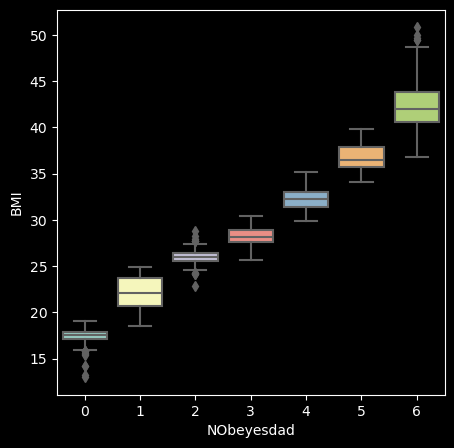

In [18]:
plt.figure(figsize=(5,5))
sns.boxplot(x ='NObeyesdad',y ='BMI', data=df_ordinal)

0. Underweight: BMI < 18.5
1. Normal weight: BMI 18.5 – 24.9
3. Overweight: BMI 25 – 29.9
4. Obesity: BMI ≥ 30

<Axes: xlabel='NObeyesdad', ylabel='Weight'>

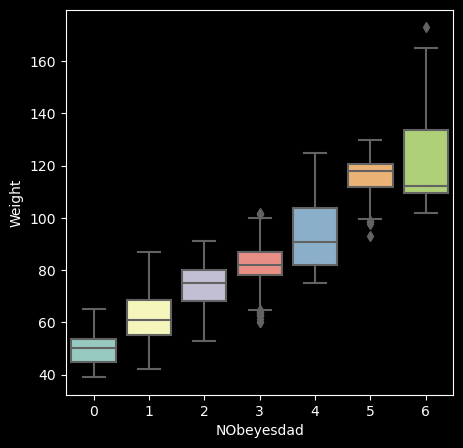

In [19]:
plt.figure(figsize=(5,5))
sns.boxplot(x ='NObeyesdad',y = 'Weight', data=df_ordinal)

In [20]:
# plt.figure(figsize=(18,8))
# sns.heatmap(data.drop(['NObeyesdad'], axis=1).corr(),annot=True, cmap="mako")

In [21]:
X = data.drop(['NObeyesdad', 'NObeyesdad_encoded'], axis=1)
y = data['NObeyesdad_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor 
# vif_data = pd.DataFrame() 
# vif_data["feature"] = X.columns  
# vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
#                           for i in range(len(X.columns))] 
# vif_data

# RandomForestClassifier

In [23]:
rfc_model_gs = RandomForestClassifier()

In [24]:
param_grid = [{
    "criterion": ["gini", "entropy", "log_loss"],
    "n_estimators": list(range(100, 120)),
    "max_depth": list(range(10, 20))
}]

In [25]:
grid_search = GridSearchCV(rfc_model_gs, param_grid, cv=3, scoring="accuracy", return_train_score=True, verbose=10)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 600 candidates, totalling 1800 fits
[CV 1/3; 1/600] START criterion=gini, max_depth=10, n_estimators=100............
[CV 1/3; 1/600] END criterion=gini, max_depth=10, n_estimators=100;, score=(train=1.000, test=0.979) total time=   1.6s
[CV 2/3; 1/600] START criterion=gini, max_depth=10, n_estimators=100............
[CV 2/3; 1/600] END criterion=gini, max_depth=10, n_estimators=100;, score=(train=1.000, test=0.977) total time=   0.1s
[CV 3/3; 1/600] START criterion=gini, max_depth=10, n_estimators=100............
[CV 3/3; 1/600] END criterion=gini, max_depth=10, n_estimators=100;, score=(train=1.000, test=0.984) total time=   0.1s
[CV 1/3; 2/600] START criterion=gini, max_depth=10, n_estimators=101............
[CV 1/3; 2/600] END criterion=gini, max_depth=10, n_estimators=101;, score=(train=1.000, test=0.986) total time=   0.1s
[CV 2/3; 2/600] START criterion=gini, max_depth=10, n_estimators=101............
[CV 2/3; 2/600] END criterion=gini, max_depth=10, n

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
                          'n_estimators': [100, 101, 102, 103, 104, 105, 106,
                                           107, 108, 109, 110, 111, 112, 113,
                                           114, 115, 116, 117, 118, 119]}],
             return_train_score=True, scoring='accuracy', verbose=10)

In [27]:
print("The best parameters are %s with a score of %0.2f"
      % (grid_search.best_params_, grid_search.best_score_))

The best parameters are {'criterion': 'entropy', 'max_depth': 16, 'n_estimators': 111} with a score of 0.99


In [28]:
grid_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
grid_results

,criterion,max_depth,n_estimators,Accuracy
0,gini,10,100,0.979860
1,gini,10,101,0.985783
2,gini,10,102,0.984006
3,gini,10,103,0.985782
4,gini,10,104,0.986373
...,...,...,...,...
595,log_loss,19,115,0.984599
596,log_loss,19,116,0.985193
597,log_loss,19,117,0.986375
598,log_loss,19,118,0.986376


In [29]:
grid_contour = grid_results.groupby(['criterion','max_depth','n_estimators']).mean()
grid_contour

Accuracy
criterion max_depth n_estimators          
entropy   10        100           0.984006
                    101           0.985190
                    102           0.987559
                    103           0.983415
                    104           0.982821
...                                    ...
log_loss  19        115           0.984599
                    116           0.985193
                    117           0.986375
                    118           0.986376
                    119           0.984597

[600 rows x 1 columns]

In [121]:
rfc_model = RandomForestClassifier(criterion='entropy', 
                                   n_estimators=111, 
                                   max_depth=16,
                                   min_samples_split=3,
                                   min_samples_leaf=2,
                                   random_state=1)

In [122]:
cv_scores = cross_val_score(rfc_model, X, y, cv=5)
mean_cv_score = np.mean(cv_scores) 
print(f"Mean Cross-Validation Score: {mean_cv_score}")

Mean Cross-Validation Score: 0.9772926400233045


In [123]:
rfc_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=16, min_samples_leaf=2,
                       min_samples_split=3, n_estimators=111, random_state=1)

In [124]:
y_pred_rfc = rfc_model.predict(X_test)
y_prob_rfc = rfc_model.predict_proba(X_test)[:, 1]

In [125]:
rfc_score = rfc_model.score(X_test, y_test)
accuracy_rfc = round(rfc_score*100, 1)
print(f"Accuracy: {accuracy_rfc}%")

Accuracy: 98.6%


In [126]:
pd.crosstab(y_test, y_pred_rfc)

col_0,0,1,2,3,4,5,6
NObeyesdad_encoded,,,,,,,
0,55,1,0,0,0,0,0
1,1,61,0,0,0,0,0
2,0,2,54,0,0,0,0
3,0,0,0,50,0,0,0
4,0,0,0,0,77,1,0
5,0,0,0,0,1,57,0
6,0,0,0,0,0,0,63


In [127]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        56
           1       0.95      0.98      0.97        62
           2       1.00      0.96      0.98        56
           3       1.00      1.00      1.00        50
           4       0.99      0.99      0.99        78
           5       0.98      0.98      0.98        58
           6       1.00      1.00      1.00        63

    accuracy                           0.99       423
   macro avg       0.99      0.99      0.99       423
weighted avg       0.99      0.99      0.99       423



In [135]:
importances = rfc_model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': X.columns, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)

                           Feature  Gini Importance
26                             BMI         0.379628
3                           Weight         0.216945
6                             FCVC         0.079340
1                              Age         0.054291
2                           Height         0.045338
0                           Gender         0.041520
7                              NCP         0.027875
12                             TUE         0.021114
4   family_history_with_overweight         0.020760
9                             CH2O         0.020357
11                             FAF         0.018161
15                  CAEC_Sometimes         0.013544
19                  CALC_Sometimes         0.012902
14                 CAEC_Frequently         0.011992
20                         CALC_no         0.009341
5                             FAVC         0.007314
24    MTRANS_Public_Transportation         0.007088
21               MTRANS_Automobile         0.004805
10          

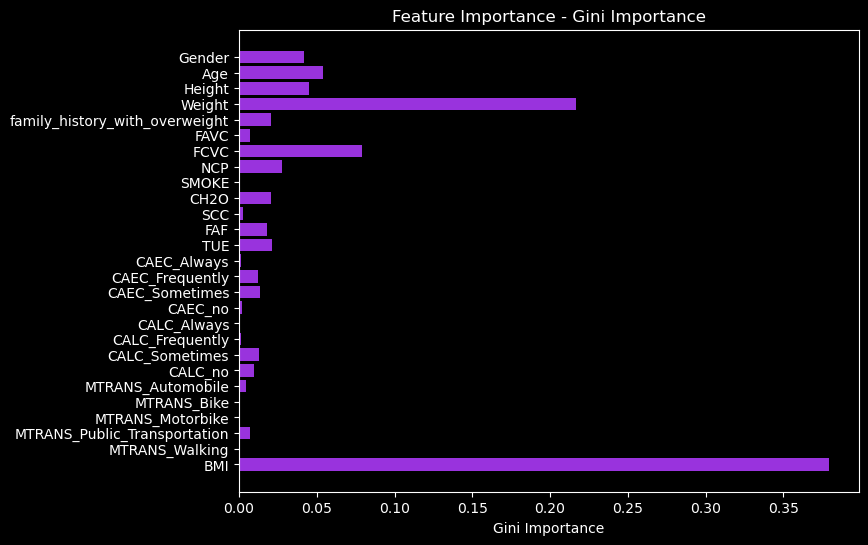

In [139]:
plt.figure(figsize=(8, 6))
plt.barh(X.columns, importances, color='#93d')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()
plt.show()

In [128]:
# import joblib
# joblib.dump(rfc_model, "model.joblib")

['model.joblib']

# KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier

In [32]:
knn_model = KNeighborsClassifier(n_neighbors=10)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [33]:
y_pred_knn = knn_model.predict(X_test)

In [34]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91        56
           1       0.91      0.68      0.78        62
           2       0.82      0.91      0.86        56
           3       0.96      0.96      0.96        50
           4       0.97      0.99      0.98        78
           5       0.98      0.97      0.97        58
           6       0.98      1.00      0.99        63

    accuracy                           0.93       423
   macro avg       0.93      0.93      0.92       423
weighted avg       0.93      0.93      0.92       423



In [35]:
pd.crosstab(y_test, y_pred_knn)

col_0,0,1,2,3,4,5,6
NObeyesdad_encoded,,,,,,,
0,55,1,0,0,0,0,0
1,10,42,10,0,0,0,0
2,0,3,51,2,0,0,0
3,0,0,1,48,1,0,0
4,0,0,0,0,77,1,0
5,0,0,0,0,1,56,1
6,0,0,0,0,0,0,63


In [36]:
accuracy_knn = round(metrics.accuracy_score(y_test, y_pred_knn)*100, 2)
print(f"The Accuracy of KNN: {accuracy_knn}%")

The Accuracy of KNN: 92.67%


# Decision Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [38]:
y_pred_tree = tree_model.predict(X_test)

In [39]:
accuracy_tree = round(tree_model.score(X_test, y_test)*100, 1)
accuracy_tree

96.7

In [40]:
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95        56
           1       0.91      0.95      0.93        62
           2       0.98      0.91      0.94        56
           3       0.96      1.00      0.98        50
           4       1.00      0.96      0.98        78
           5       0.95      1.00      0.97        58
           6       1.00      1.00      1.00        63

    accuracy                           0.97       423
   macro avg       0.97      0.97      0.97       423
weighted avg       0.97      0.97      0.97       423



In [41]:
pd.crosstab(y_test, y_pred_tree)

col_0,0,1,2,3,4,5,6
NObeyesdad_encoded,,,,,,,
0,53,3,0,0,0,0,0
1,2,59,1,0,0,0,0
2,0,3,51,2,0,0,0
3,0,0,0,50,0,0,0
4,0,0,0,0,75,3,0
5,0,0,0,0,0,58,0
6,0,0,0,0,0,0,63


# SVC

In [42]:
from sklearn.svm import SVC
svmclassifier_model = SVC(random_state=1, kernel='poly', degree=10) #poly, rbf, sigmoid (without "degree" parameter)| rbf is the best one
svmclassifier_model.fit(X_train, y_train)

SVC(degree=10, kernel='poly', random_state=1)

In [43]:
y_pred_svm = svmclassifier_model.predict(X_test)

In [44]:
pd.crosstab(y_test, y_pred_svm)

col_0,0,1,2,3,4,5,6
NObeyesdad_encoded,,,,,,,
0,56,0,0,0,0,0,0
1,42,8,12,0,0,0,0
2,14,8,31,3,0,0,0
3,1,2,23,23,1,0,0
4,0,0,0,11,66,1,0
5,0,0,0,0,0,58,0
6,0,0,0,0,0,0,63


In [45]:
accuracy_svm = round(svmclassifier_model.score(X_test, y_test)*100, 1)
accuracy_svm

72.1

In [46]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.50      1.00      0.66        56
           1       0.44      0.13      0.20        62
           2       0.47      0.55      0.51        56
           3       0.62      0.46      0.53        50
           4       0.99      0.85      0.91        78
           5       0.98      1.00      0.99        58
           6       1.00      1.00      1.00        63

    accuracy                           0.72       423
   macro avg       0.71      0.71      0.69       423
weighted avg       0.73      0.72      0.70       423



# Naive Bayes

In [47]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB().fit(X_train, y_train)

In [48]:
gnb_predictions = gnb.predict(X_test)
accuracy_gnb = round(gnb.score(X_test, y_test)*100, 1) 
pd.crosstab(y_test, gnb_predictions)

col_0,0,1,2,3,4,5,6
NObeyesdad_encoded,,,,,,,
0,55,1,0,0,0,0,0
1,24,27,8,3,0,0,0
2,0,3,20,33,0,0,0
3,0,1,0,28,21,0,0
4,0,3,0,2,57,16,0
5,0,0,0,0,1,57,0
6,0,0,0,0,0,0,63


In [49]:
accuracy_gnb

72.6

In [50]:
models_accuracy = pd.Series({
    "RandomForest": accuracy_rfc,
    "Tree": accuracy_tree,
    "KNN": accuracy_knn,
    "SVM": accuracy_svm,
    "Naive Bayes": accuracy_gnb,
})
models = pd.DataFrame(models_accuracy)
models = models.rename(columns={0:"Accuracy"})

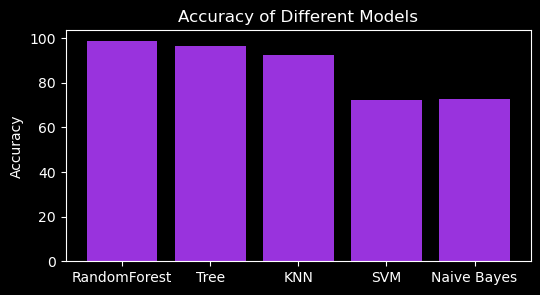

In [51]:
plt.figure(figsize=(6,3))
plt.bar(models.index, models["Accuracy"], color='#93d')
#plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.show()

In [52]:
models

,Accuracy
RandomForest,98.60
Tree,96.70
KNN,92.67
SVM,72.10
Naive Bayes,72.60


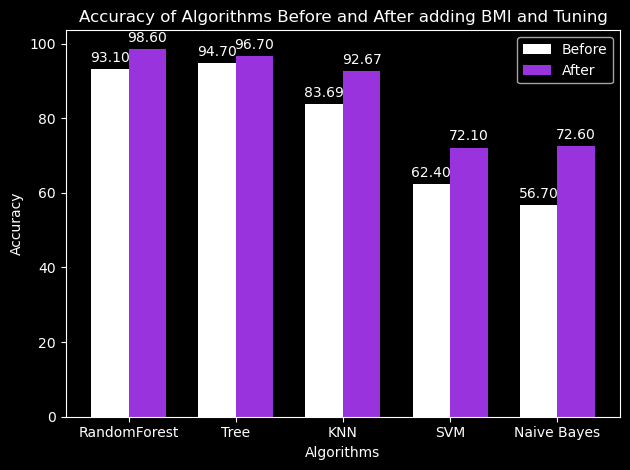

In [53]:
algorithms = ['RandomForest', 'Tree', 'KNN', 'SVM', 'Naive Bayes']
accuracy_before = [93.1, 94.7, 83.69, 62.4, 56.7]
accuracy_after = [accuracy_rfc, accuracy_tree, accuracy_knn, accuracy_svm, accuracy_gnb]
num_algorithms = len(algorithms)
indices = np.arange(num_algorithms)
bar_width = 0.35
fig, ax = plt.subplots()

bars_before = ax.bar(indices, accuracy_before, bar_width, label='Before', color="white")
bars_after = ax.bar(indices + bar_width, accuracy_after, bar_width, label='After', color="#93d")

ax.set_xlabel('Algorithms')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of Algorithms Before and After adding BMI and Tuning')
ax.set_xticks(indices + bar_width / 2)
ax.set_xticklabels(algorithms)
ax.legend()

for bars in [bars_before, bars_after]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [2]:
import optuna

In [3]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 32)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32) 

    model = RandomForestClassifier(n_estimators, max_depth, min_samples_split, min_samples_leaf)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    return score

# Binary Classification (данный раздел является экспериментальным, так что нет необходимости рассматривать его)

In [79]:
data1 = data.drop(['NObeyesdad'], axis=1)

In [80]:
data1['NObeyesdad_encoded'] = data1['NObeyesdad_encoded'].map({0:0, 1:0, 2:0, 3:0, 4:1, 5:1, 6:1})

In [81]:
Xx = data1.drop(['NObeyesdad_encoded'], axis=1)
yy = data1['NObeyesdad_encoded']
Xx_train, Xx_test, yy_train, yy_test = train_test_split(Xx, yy, test_size=0.2, random_state=42)

In [82]:
data1 = data1.rename(columns={'NObeyesdad_encoded':'status'})

In [83]:
data1.status.value_counts()

status
0    1139
1     972
Name: count, dtype: int64

In [84]:
data1.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,...,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,status,BMI
0,0,21.0,1.62,64.0,1,0,2.0,3.0,0,2.0,...,0,0,1,0,0,0,1,0,0,24.386526
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,3.0,...,0,1,0,0,0,0,1,0,0,24.238227
2,1,23.0,1.80,77.0,1,0,2.0,3.0,0,2.0,...,1,0,0,0,0,0,1,0,0,23.765432
3,1,27.0,1.80,87.0,0,0,3.0,3.0,0,2.0,...,1,0,0,0,0,0,0,1,0,26.851852
4,1,22.0,1.78,89.8,0,0,2.0,1.0,0,2.0,...,0,1,0,0,0,0,1,0,0,28.342381


In [88]:
logreg_model = LogisticRegression()
logreg_model.fit(Xx_train, yy_train)
y_pred_logreg = logreg_model.predict(Xx_test)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [89]:
pd.crosstab(yy_test, y_pred_logreg)

col_0,0,1
NObeyesdad_encoded,,
0,221,3
1,1,198


In [90]:
print(classification_report(yy_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       224
           1       0.99      0.99      0.99       199

    accuracy                           0.99       423
   macro avg       0.99      0.99      0.99       423
weighted avg       0.99      0.99      0.99       423



In [91]:
print(f"The accuracy of logreg: {metrics.accuracy_score(yy_test, y_pred_logreg)}")
print(f"F1 Score: {metrics.f1_score(yy_test, y_pred_logreg)}")
print(f"Precision Score: {metrics.precision_score(yy_test, y_pred_logreg)}")

The accuracy of logreg: 0.9905437352245863
F1 Score: 0.99
Precision Score: 0.9850746268656716


In [95]:
auc_logreg = metrics.roc_auc_score(yy_test, y_prob_logreg)
auc_logreg

0.999775664034458

In [98]:
tree_model.fit(Xx_train, yy_train)
y_pred_tree = tree_model.predict(Xx_test)
pd.crosstab(yy_test, y_pred_tree)

col_0,0,1
NObeyesdad_encoded,,
0,224,0
1,0,199


In [99]:
rfc_ = RandomForestClassifier(criterion='gini',
                                 n_estimators=41,
                                 random_state=None,
                                 n_jobs=None)
rfc_.fit(Xx_train, yy_train)
y_pred_rfc_ = rfc_.predict(Xx_test)

In [100]:
pd.crosstab(yy_test, y_pred_rfc_)

col_0,0,1
NObeyesdad_encoded,,
0,224,0
1,0,199


In [103]:
knn_model_ = KNeighborsClassifier(n_neighbors=110)
knn_model_.fit(Xx_train, yy_train)
y_pred_knn_ = knn_model_.predict(Xx_test)

In [104]:
pd.crosstab(yy_test, y_pred_knn_)

col_0,0,1
NObeyesdad_encoded,,
0,219,5
1,16,183


In [107]:
from sklearn.svm import SVC
svmclassifier_model = SVC(probability=True, random_state=42, kernel='rbf', degree=8) #poly, rbf, sigmoid (without "degree" parameter)| rbf is the best one
svmclassifier_model.fit(Xx_train, yy_train)
y_pred_svm_ = svmclassifier_model.predict(Xx_test)

In [108]:
pd.crosstab(yy_test, y_pred_svm_)

col_0,0,1
NObeyesdad_encoded,,
0,220,4
1,19,180


In [119]:
y_prob_rfc_ = rfc_.predict_proba(Xx_test)[:, 1]
y_prob_tree = tree_model.predict_proba(Xx_test)[:, 1]
y_prob_knn_ = knn_model_.predict_proba(Xx_test)[:, 1]
y_prob_svm_ = svmclassifier_model.predict_proba(Xx_test)[:, 1]
testing_clmod = pd.DataFrame(
    {
        'True': yy_test, 'Logistic Regression': y_prob_logreg, 'RandomForestClassifier': y_prob_rfc_,
        'DecisionTreeClassifier': y_prob_tree, 'KNN': y_prob_knn_, 'SVM': y_prob_svm_
    })

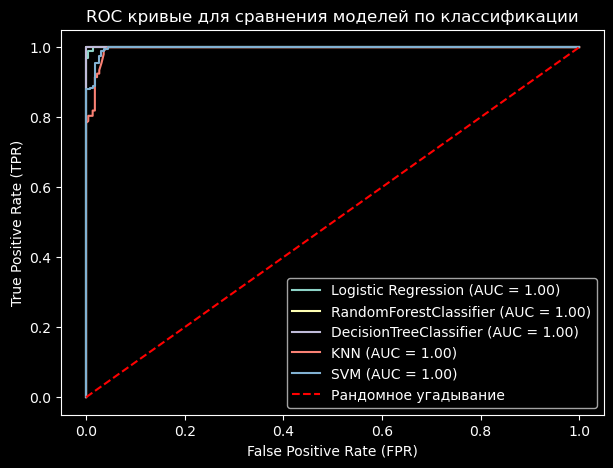

In [120]:
plt.figure(figsize=(7, 5))
for model in ['Logistic Regression','RandomForestClassifier', 'DecisionTreeClassifier', 'KNN', 'SVM']:
    fpr, tpr, _ = roc_curve(testing_clmod['True'], testing_clmod[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Рандомное угадывание')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC кривые для сравнения моделей по классификации')
plt.legend()
plt.show()